## Prepare datasets

In [1]:
from google.colab import drive

drive.mount("/content/drive")  # Mount Google Drive to access dataset files

Mounted at /content/drive


In [2]:
import os

# Define dataset paths for training and test images/annotations
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset Self Driving Car"

IMAGE_TRAIN_PATH = os.path.join(DATA_PATH, "images_prepped_train-20230811T065243Z-001", "images_prepped_train")
LABEL_TRAIN_PATH = os.path.join(DATA_PATH, "annotations_prepped_train-20230811T065240Z-001", "annotations_prepped_train")
IMAGE_TEST_PATH = os.path.join(DATA_PATH, "images_prepped_test-20230811T065241Z-001", "images_prepped_test")
LABEL_TEST_PATH = os.path.join(DATA_PATH, "annotations_prepped_test-20230811T065240Z-001", "annotations_prepped_test")

In [3]:
os.listdir(DATA_PATH)  # List contents of the main dataset folder to verify structure

['images_prepped_train-20230811T065243Z-001',
 'annotations_prepped_test-20230811T065240Z-001',
 'images_prepped_test-20230811T065241Z-001',
 'annotations_prepped_train-20230811T065240Z-001']

In [4]:
# Print the number of training and test images and labels
print("Train Images:", len(os.listdir(IMAGE_TRAIN_PATH)))
print("Train Labels:", len(os.listdir(LABEL_TRAIN_PATH)))
print("Test Images:", len(os.listdir(IMAGE_TEST_PATH)))
print("Test Labels:", len(os.listdir(LABEL_TEST_PATH)))

Train Images: 398
Train Labels: 367
Test Images: 101
Test Labels: 101


In [5]:
# Quick check for mismatched files
train_images = set(os.listdir(IMAGE_TRAIN_PATH))
train_labels = set(os.listdir(LABEL_TRAIN_PATH))

missing_labels = train_images - train_labels
if missing_labels:
    print("Missing labels for these images:", missing_labels)
else:
    print("All training labels are present.")  # Ensure every training image has a corresponding label

Missing labels for these images: {'0006R0_f03840(1).png', '0016E5_05400(1).png', '0006R0_f03780(1).png', '0016E5_07800(1).png', '0016E5_07920(1).png', '0006R0_f03720(1).png', '0006R0_f03690(1).png', '0016E5_07650(1).png', '0016E5_07740(1).png', '0016E5_07830(1).png', '0006R0_f03750(1).png', '0016E5_07770(2).png', '0016E5_07920(2).png', '0016E5_07650(2).png', '0016E5_07620(1).png', '0006R0_f03810(1).png', '0016E5_07680(1).png', '0006R0_f03630(1).png', '0016E5_07710(1).png', '0006R0_f03660(1).png', '0016E5_07860(1).png', '0016E5_07740(2).png', '0006R0_f03600(1).png', '0016E5_07830(2).png', '0016E5_07800(2).png', '0016E5_07620(2).png', '0016E5_07770(1).png', '0016E5_07860(2).png', '0016E5_07710(2).png', '0016E5_07680(2).png', '0006R0_f03930(1).png'}


In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

# Custom Dataset class for semantic segmentation
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        # Get list of image and label files
        image_files = set(os.listdir(image_dir))
        label_files = set(os.listdir(label_dir))

        # Keep only files that exist in both image and label folders
        matched_files = sorted(image_files & label_files)

        # Full paths to matched image and label files
        self.image_paths = [os.path.join(image_dir, fname) for fname in matched_files]
        self.label_paths = [os.path.join(label_dir, fname) for fname in matched_files]

        print(f"Loaded {len(self.image_paths)} matched image-label pairs.")

    def __len__(self):
        # Return total number of samples
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and label as arrays
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        label = np.array(Image.open(self.label_paths[idx])).astype(np.int64)

        # Apply augmentation/transform if provided
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented["image"]
            label = augmented["mask"]

        return image, label  # Return image and corresponding label (mask)

## Import Library

In [7]:
# Core libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # For plotting and visualization

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset  # For handling data loading and custom datasets

# Image Augmentation
import albumentations as A  # Image augmentation library
from albumentations.pytorch import ToTensorV2  # Convert image to PyTorch tensor format

# For progress bars
from tqdm.notebook import tqdm  # Progress bar for notebooks (Colab-friendly)

## Datasets Loader

In [8]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

# Custom dataset class to load image-mask pairs from directories
class CityScapes(Dataset):
    def __init__(self, image_folder_path, mask_folder_path, transform=None):
        self.image_folder_path = image_folder_path
        self.mask_folder_path = mask_folder_path
        self.transform = transform

        # Only include files that exist in both folders
        image_files = set(os.listdir(image_folder_path))
        mask_files = set(os.listdir(mask_folder_path))
        matched_files = sorted(image_files & mask_files)

        self.image_paths = [os.path.join(image_folder_path, f) for f in matched_files]
        self.mask_paths = [os.path.join(mask_folder_path, f) for f in matched_files]

        print(f"Loaded {len(self.image_paths)} matched image-mask pairs.")

    def __len__(self):
        # Number of image-mask pairs
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load the image and mask
        image = np.array(Image.open(self.image_paths[index]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[index]))

        # Apply transformation if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Image size
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Transform for training (with augmentation)
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Transform for validation/test (no augmentation)
val_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [10]:
from torch.utils.data import Subset
import torch
import random

# 1. Set a fixed seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# 2. Create full list of indices
full_dataset = CityScapes(
    image_folder_path=IMAGE_TRAIN_PATH,
    mask_folder_path=LABEL_TRAIN_PATH,
    transform=None  # Assign transform separately per split
)

indices = list(range(len(full_dataset)))
random.shuffle(indices)

# 3. Split indices manually
val_size = int(0.2 * len(full_dataset))
train_indices = indices[val_size:]
val_indices = indices[:val_size]

# 4. Create two separate datasets with transforms
train_dataset = Subset(
    CityScapes(
        image_folder_path=IMAGE_TRAIN_PATH,
        mask_folder_path=LABEL_TRAIN_PATH,
        transform=train_transform
    ),
    train_indices
)

val_dataset = Subset(
    CityScapes(
        image_folder_path=IMAGE_TRAIN_PATH,
        mask_folder_path=LABEL_TRAIN_PATH,
        transform=val_transform
    ),
    val_indices
)

Loaded 367 matched image-mask pairs.
Loaded 367 matched image-mask pairs.
Loaded 367 matched image-mask pairs.


In [11]:
from torch.utils.data import DataLoader

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [12]:
# Test Dataset
test_dataset = CityScapes(
    image_folder_path=IMAGE_TEST_PATH,
    mask_folder_path=LABEL_TEST_PATH,
    transform=val_transform  # no augmentation
)

# Test DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

Loaded 101 matched image-mask pairs.


## Model Architecture

- DoubleConv

In [13]:
# A block that performs two convolutional layers with BatchNorm and ReLU (used in UNet encoder/decoder)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

- Unet

In [14]:
# UNet architecture for semantic segmentation with encoder-decoder structure and skip connections
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # Reverse for upsampling

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

- FCN8s

In [15]:
# FCN8s architecture for semantic segmentation using skip connections and transposed convolutions
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    # Downsampling path using DoubleConv blocks
    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Transposed convolution for upsampling
    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    # Final prediction layer (upsample to original input size)
    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    # Forward pass through downsampling path
    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:  # Save intermediate feature maps for skip connections
        skip_connections.append(x)

    # First upsampling + skip connection
    ups1 = self.ups1(x)
    skip1 = skip_connections[-1]
    if ups1.shape[-2:] != skip1.shape[-2:]:
        ups1 = F.interpolate(ups1, size=skip1.shape[-2:], mode='bilinear', align_corners=False)
    concat1 = torch.cat([ups1, skip1], dim=1)

    # Second upsampling + skip connection
    ups2 = self.ups2(concat1)
    skip2 = skip_connections[-2]
    if ups2.shape[-2:] != skip2.shape[-2:]:
        ups2 = F.interpolate(ups2, size=skip2.shape[-2:], mode='bilinear', align_corners=False)
    concat2 = torch.cat([ups2, skip2], dim=1)

    return self.predictions(concat2)  # Output segmentation mask

## Engine function

- Dice coefficient metrics

In [16]:
# Calculate Dice coefficient between a single pair of predicted and ground truth masks
def calculate_dice_coefficient(ground_truth, predicted, epsilon=1e-6):
    ground_truth = ground_truth.astype(bool)
    predicted = predicted.astype(bool)
    intersection = np.logical_and(ground_truth, predicted)
    dice = (2. * intersection.sum()) / (ground_truth.sum() + predicted.sum() + epsilon)
    return dice

# Calculate Dice coefficients for multiple pairs of masks
def calculate_dice_coefficients(ground_truths, predictions):
    return [calculate_dice_coefficient(gt, pred) for gt, pred in zip(ground_truths, predictions)]

- Training phase

In [17]:
import torch
import torch.nn.functional as F

# Perform one training epoch on the given dataloader
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device).long()

        # Forward pass
        outputs = model(images)

        # Resize outputs to match mask shape if needed
        if outputs.shape != masks.shape:
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

# Evaluate model performance on the validation set
def evaluate(model, dataloader, criterion, device):
    model.eval()
    eval_loss = 0.0
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).long()

            outputs = model(images)

            # Resize outputs to match masks
            if outputs.shape != masks.shape:
                outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            eval_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            gts = masks.cpu().numpy()
            all_preds.extend(preds)
            all_gts.extend(gts)

    avg_dice = np.mean(calculate_dice_coefficients(all_gts, all_preds))
    return eval_loss / len(dataloader), avg_dice

In [18]:
from torch import optim
import matplotlib.pyplot as plt

# Train a model across multiple epochs and evaluate on validation set
def train(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # use appropriate loss for multiclass masks

    train_losses = []
    val_losses = []
    val_dices = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_dice = evaluate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Dice: {val_dice:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_dices.append(val_dice)

    # Plot loss and dice
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(val_dices, label='Val Dice Coefficient')
    plt.legend()
    plt.title('Dice Coefficient')

    plt.show()

    return model

In [34]:
from collections import defaultdict
import time

# Train both UNet and FCN8s models and store results
def train_all_models():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    models = {
        "UNet": UNET(in_channels=3, out_channels=12),
        "FCN8s": FCN8s(in_channels=3, out_channels=12),
    }

    results = defaultdict(dict)

    for model_name, model in models.items():
        print(f"\nTraining {model_name}")
        start_time = time.time()
        trained_model = train(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=50,  # adjust as needed
            lr=1e-3,
            device=device
        )
        total_time = time.time() - start_time
        results[model_name]["model"] = trained_model
        results[model_name]["training_time"] = total_time
        print(f"{model_name} training completed in {total_time:.2f} seconds.")

    return results


Training UNet

Epoch 1/50
Train Loss: 1.4407
Val Loss: 2.0363
Val Dice: 0.9681

Epoch 2/50
Train Loss: 0.9596
Val Loss: 0.9714
Val Dice: 0.9842

Epoch 3/50
Train Loss: 0.8035
Val Loss: 0.6972
Val Dice: 0.9872

Epoch 4/50
Train Loss: 0.7254
Val Loss: 0.7169
Val Dice: 0.9800

Epoch 5/50
Train Loss: 0.7056
Val Loss: 0.6025
Val Dice: 0.9856

Epoch 6/50
Train Loss: 0.6857
Val Loss: 0.6602
Val Dice: 0.9731

Epoch 7/50
Train Loss: 0.6481
Val Loss: 0.6487
Val Dice: 0.9847

Epoch 8/50
Train Loss: 0.6446
Val Loss: 0.6571
Val Dice: 0.9791

Epoch 9/50
Train Loss: 0.6222
Val Loss: 0.6827
Val Dice: 0.9794

Epoch 10/50
Train Loss: 0.6055
Val Loss: 0.5026
Val Dice: 0.9883

Epoch 11/50
Train Loss: 0.5698
Val Loss: 0.6124
Val Dice: 0.9869

Epoch 12/50
Train Loss: 0.6075
Val Loss: 0.6072
Val Dice: 0.9885

Epoch 13/50
Train Loss: 0.5480
Val Loss: 0.4841
Val Dice: 0.9884

Epoch 14/50
Train Loss: 0.5389
Val Loss: 0.5106
Val Dice: 0.9887

Epoch 15/50
Train Loss: 0.5010
Val Loss: 0.4647
Val Dice: 0.9882

Epo

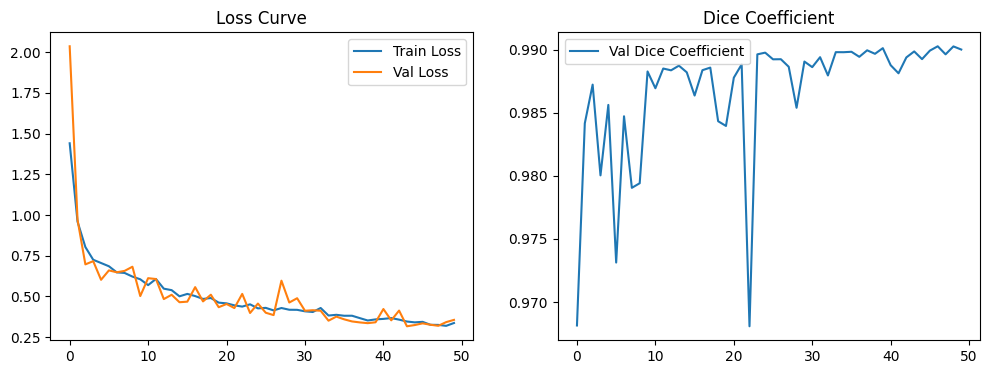

UNet training completed in 996.65 seconds.

Training FCN8s

Epoch 1/50
Train Loss: 1.2327
Val Loss: 1.0016
Val Dice: 0.9783

Epoch 2/50
Train Loss: 0.8918
Val Loss: 0.9016
Val Dice: 0.9772

Epoch 3/50
Train Loss: 0.8141
Val Loss: 0.7918
Val Dice: 0.9669

Epoch 4/50
Train Loss: 0.7215
Val Loss: 0.6310
Val Dice: 0.9781

Epoch 5/50
Train Loss: 0.6571
Val Loss: 0.7247
Val Dice: 0.9852

Epoch 6/50
Train Loss: 0.6489
Val Loss: 0.5565
Val Dice: 0.9850

Epoch 7/50
Train Loss: 0.6171
Val Loss: 0.5742
Val Dice: 0.9842

Epoch 8/50
Train Loss: 0.6324
Val Loss: 0.6005
Val Dice: 0.9828

Epoch 9/50
Train Loss: 0.5774
Val Loss: 0.5032
Val Dice: 0.9845

Epoch 10/50
Train Loss: 0.5581
Val Loss: 0.4871
Val Dice: 0.9866

Epoch 11/50
Train Loss: 0.5147
Val Loss: 0.5743
Val Dice: 0.9848

Epoch 12/50
Train Loss: 0.4981
Val Loss: 0.5175
Val Dice: 0.9837

Epoch 13/50
Train Loss: 0.5612
Val Loss: 0.7226
Val Dice: 0.9840

Epoch 14/50
Train Loss: 0.5305
Val Loss: 0.5657
Val Dice: 0.9849

Epoch 15/50
Train Loss: 0

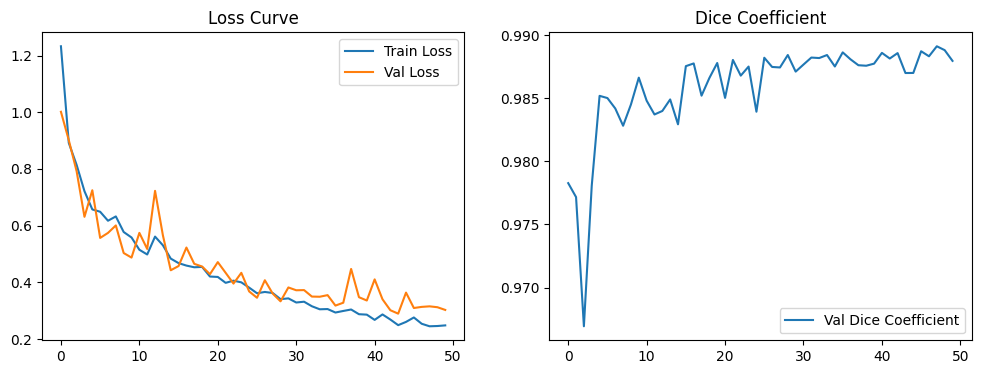

FCN8s training completed in 429.40 seconds.


In [35]:
# Train all models
train_results = train_all_models()

- Testing phase

In [36]:
# Calculate IoU per class between ground truth and prediction masks
def calculate_iou_per_class(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:
            ious.append(np.nan)  # Skip classes not present in either prediction or ground truth
        else:
            ious.append(intersection / union)
    return ious

# Calculate mean IoU (mIoU) across all classes and images
def calculate_miou(y_true_list, y_pred_list, num_classes):
    all_ious = []
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        ious = calculate_iou_per_class(y_true, y_pred, num_classes)
        all_ious.append(ious)
    all_ious = np.array(all_ious)
    miou = np.nanmean(all_ious, axis=0)  # Mean IoU per class
    return miou, np.nanmean(miou)        # (per-class IoU, overall mIoU)

In [37]:
# Evaluate a single model on the test dataset and return loss, Dice, mIoU, and predictions
def test_model(model, dataloader, criterion, device):
    model.eval()
    model.to(device)

    test_loss = 0.0
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).long()

            outputs = model(images)

            # Resize prediction to match ground truth if needed
            if outputs.shape[2:] != masks.shape[1:]:
                outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            gts = masks.cpu().numpy()
            all_preds.extend(preds)
            all_gts.extend(gts)

    avg_dice = np.mean(calculate_dice_coefficients(all_gts, all_preds))  # Average Dice across test set

    num_classes = np.max(all_gts) + 1  # Automatically determine number of classes
    class_ious, mean_iou = calculate_miou(all_gts, all_preds, num_classes)

    return test_loss / len(dataloader), avg_dice, class_ious, mean_iou, all_preds, all_gts

In [38]:
# Run testing on all trained models and store the metrics
def test_all_models(results, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    criterion = nn.CrossEntropyLoss()

    for model_name, model_info in results.items():
        model = model_info["model"]
        print(f"\n🧪 Evaluating {model_name} on test set...")

        test_loss, test_dice, class_ious, mean_iou, preds, gts = test_model(
            model=model,
            dataloader=test_loader,
            criterion=criterion,
            device=device
        )

        results[model_name]["test_loss"] = test_loss
        results[model_name]["test_dice"] = test_dice
        results[model_name]["class_ious"] = class_ious
        results[model_name]["mean_iou"] = mean_iou
        results[model_name]["preds"] = preds
        results[model_name]["gts"] = gts

        print(f"📉 Test Loss ({model_name}): {test_loss:.4f}")
        print(f"🎯 Test Dice Coefficient ({model_name}): {test_dice:.4f}")

    return results

In [39]:
# Test all models
test_results = test_all_models(train_results, test_loader)


🧪 Evaluating UNet on test set...
📉 Test Loss (UNet): 0.3470
🎯 Test Dice Coefficient (UNet): 0.9965

🧪 Evaluating FCN8s on test set...
📉 Test Loss (FCN8s): 0.3460
🎯 Test Dice Coefficient (FCN8s): 0.9960


## Evaluation

- Results summary

In [40]:
# Plot Test Dice and Loss for each model
def plot_test_results(test_results):
    model_names = list(test_results.keys())
    test_dices = [test_results[name]["test_dice"] for name in model_names]
    test_losses = [test_results[name]["test_loss"] for name in model_names]

    plt.figure(figsize=(10, 4))

    # Test Dice Coefficient
    plt.subplot(1, 2, 1)
    plt.bar(model_names, test_dices, color='green')
    plt.title("Test Dice Coefficient")
    plt.ylim(0, 1.0)
    plt.ylabel("Dice Score")

    # Test Loss
    plt.subplot(1, 2, 2)
    plt.bar(model_names, test_losses, color='red')
    plt.title("Test Loss")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

In [41]:
# Print summary comparison for all models
def print_model_comparison(test_results):
    print("\nModel Performance Summary (on Test Set)")
    print("-" * 80)
    print(f"{'Model':<15} {'Test Dice':<15} {'Test Loss':<15} {'mIoU':<15} {'Train Time (s)':<15}")
    print("-" * 80)

    for name, result in test_results.items():
        dice = result.get("test_dice", 0)
        loss = result.get("test_loss", 0)
        miou = result.get("mean_iou", 0)
        time = result.get("training_time", 0)
        print(f"{name:<15} {dice:<15.4f} {loss:<15.4f} {miou:<15.4f} {time:<15.2f}")

    print("-" * 80)

In [42]:
# Plot normalized confusion matrix for a selected model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(model_name, test_results, class_names=None, figsize=(8, 6), fontsize=10):
    preds = []
    gts = []

    for y_true, y_pred in zip(test_results[model_name]["gts"], test_results[model_name]["preds"]):
        gts.extend(y_true.flatten())
        preds.extend(y_pred.flatten())

    num_classes = len(test_results[model_name]["class_ious"])
    cm = confusion_matrix(gts, preds, labels=range(num_classes))

    # Normalize to percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized = np.nan_to_num(cm_normalized)  # replace NaN from zero-division
    cm_df = pd.DataFrame(cm_normalized * 100, index=class_names or [str(i) for i in range(num_classes)],
                         columns=class_names or [str(i) for i in range(num_classes)])

    # Plot with seaborn
    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt=".1f", cmap="Blues", cbar=True, square=True,
                linewidths=0.5, linecolor='gray', annot_kws={"size": fontsize})
    plt.title(f"Confusion Matrix (Normalized %) - {model_name}", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.tight_layout()
    plt.show()

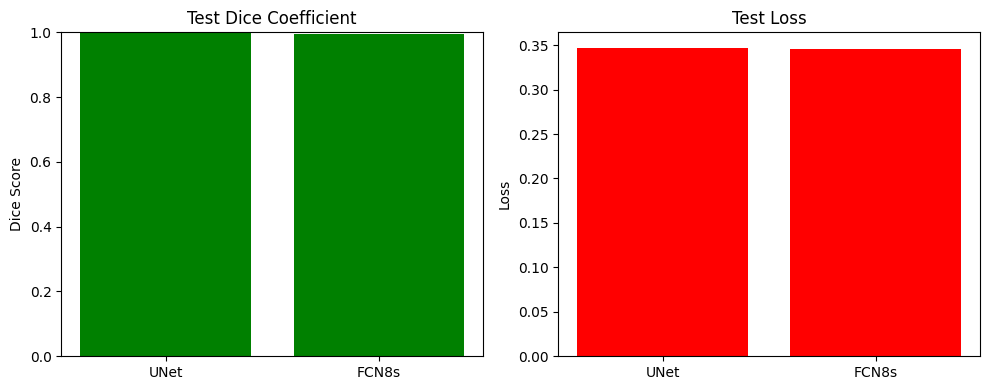


Model Performance Summary (on Test Set)
--------------------------------------------------------------------------------
Model           Test Dice       Test Loss       mIoU            Train Time (s) 
--------------------------------------------------------------------------------
UNet            0.9965          0.3470          0.5111          996.65         
FCN8s           0.9960          0.3460          0.5280          429.40         
--------------------------------------------------------------------------------


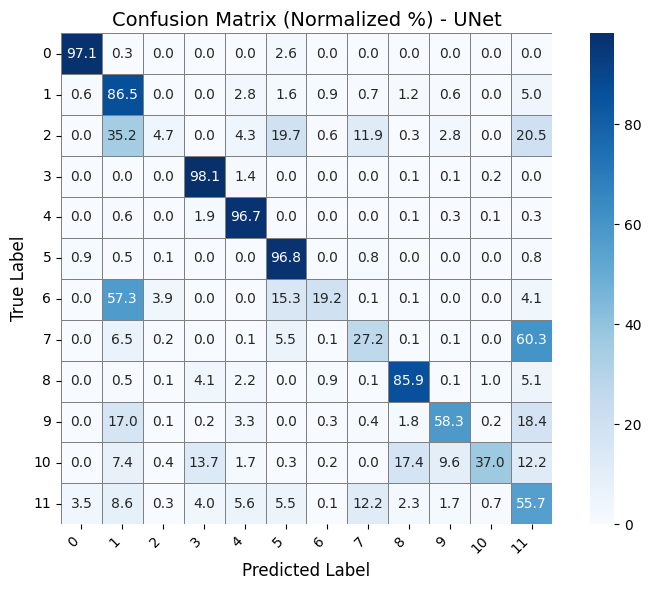

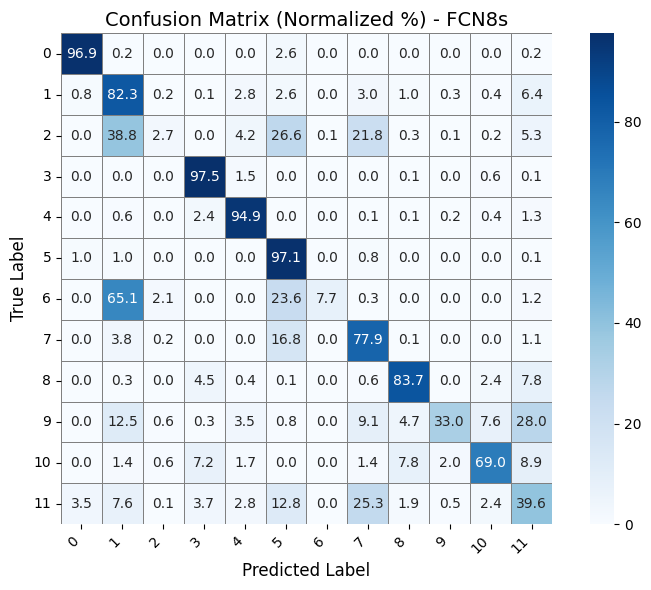

In [43]:
# Run evaluation visualizations for UNet and FCN8s
plot_test_results(test_results)
print_model_comparison(test_results)
plot_confusion_matrix("UNet", test_results)
plot_confusion_matrix("FCN8s", test_results)

- Inference

In [44]:
# Run inference on a single image and return original and predicted mask
def run_inference(model, image_path, transform, device):
    import numpy as np
    from PIL import Image
    import torch

    model.eval()
    model.to(device)

    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    original_size = image.shape[:2]  # (height, width)
    augmented = transform(image=image)
    input_tensor = augmented["image"].unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Resize prediction back to original image size
    pred_mask_resized = Image.fromarray(pred_mask.astype(np.uint8)).resize(original_size[::-1], resample=Image.NEAREST)
    pred_mask = np.array(pred_mask_resized)

    return image, pred_mask

In [45]:
# Visualize input image and its predicted mask
import matplotlib.pyplot as plt

def visualize_prediction(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="jet")  # You can change colormap if needed
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [46]:
# Overlay predicted mask on original image
def overlay_prediction(image, mask, alpha=0.6, colormap=plt.cm.jet):
    color_mask = colormap(mask / mask.max())[:, :, :3]  # Normalize and extract RGB channels
    overlay = (alpha * (image / 255.0) + (1 - alpha) * color_mask)

    plt.figure(figsize=(8, 4))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Overlay of Prediction")
    plt.show()

Saving history-google-maps-google-street-view-market-1024x682.jpg to history-google-maps-google-street-view-market-1024x682 (1).jpg


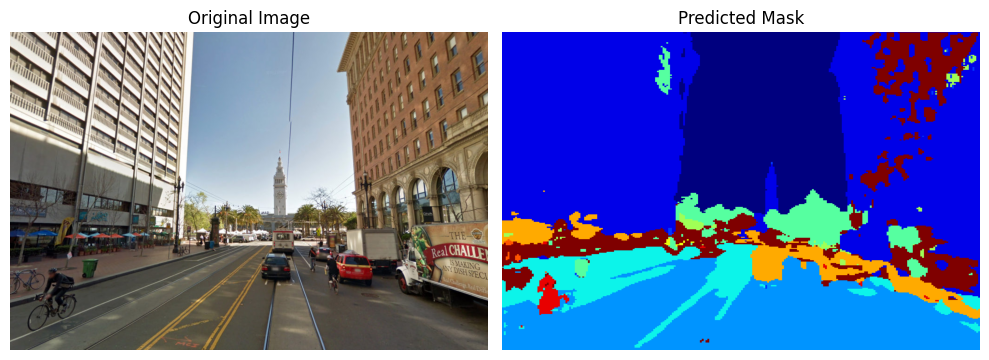

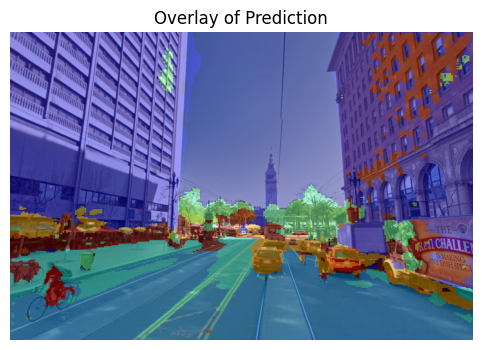

In [47]:
# Upload, infer, and visualize prediction result
from google.colab import files

# Upload an image from your local machine
uploaded = files.upload()

# Get the first uploaded file path
uploaded_image_path = next(iter(uploaded))

# Run inference
image, pred_mask = run_inference(
    model=test_results["UNet"]["model"],
    image_path=uploaded_image_path,
    transform=val_transform,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Show results
visualize_prediction(image, pred_mask)

# Resize mask if needed before overlay
if pred_mask.shape != image.shape[:2]:
    from PIL import Image
    pred_mask = Image.fromarray(pred_mask.astype(np.uint8)).resize(image.shape[1::-1], resample=Image.NEAREST)
    pred_mask = np.array(pred_mask)

overlay_prediction(image, pred_mask)

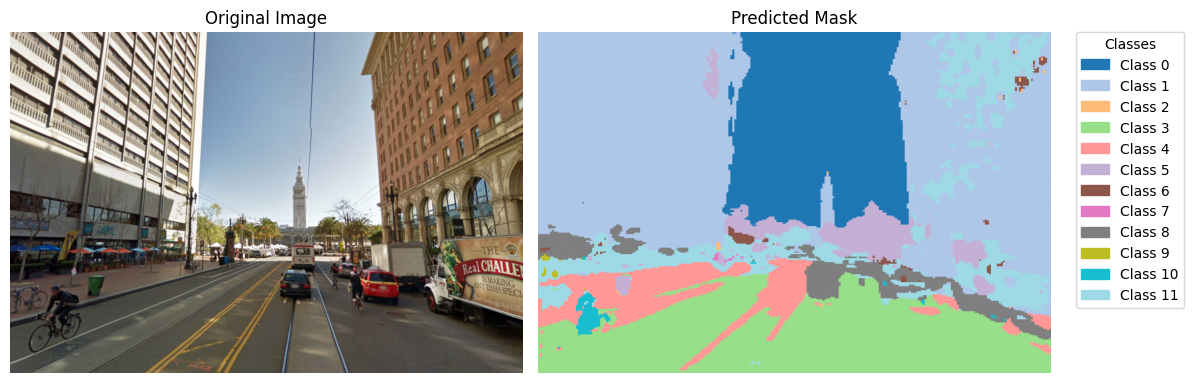

In [48]:
# Visualize predicted mask with class legend
def visualize_prediction(image, mask, num_classes=12):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.colors import ListedColormap
    import numpy as np

    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Segmentation Mask
    plt.subplot(1, 2, 2)

    # Define a colormap (jet or a custom one)
    cmap = plt.get_cmap("tab20", num_classes)
    im = plt.imshow(mask, cmap=cmap, vmin=0, vmax=num_classes - 1)
    plt.title("Predicted Mask")
    plt.axis("off")

    # Create a legend
    handles = [mpatches.Patch(color=cmap(i), label=f'Class {i}') for i in range(num_classes)]
    plt.legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        title="Classes"
    )

    plt.tight_layout()
    plt.show()

# Run visualization with legend
visualize_prediction(image, pred_mask)